"То отступ лишний  
То фразы torch не хватает"  
Везде где операция происходит с тензорами делаешь type  и смотришь какая переменная у тебя в памяти а какая на гпу  


Исходник ноутбука: https://www.kaggle.com/code/imcr00z/segmentation-skin-cancer-addi-project/notebook

На лоссы нацепить сигмоиды

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Базовый поток. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>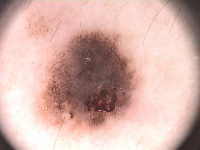</td><td>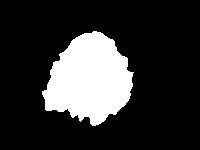</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar

Downloading...
From: https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7
To: /content/PH2Dataset.rar
100% 116M/116M [00:00<00:00, 363MB/s]


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]
## что значит resize() > 0.5? Попиксельно делает и получается картинка с 0 и 1?

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

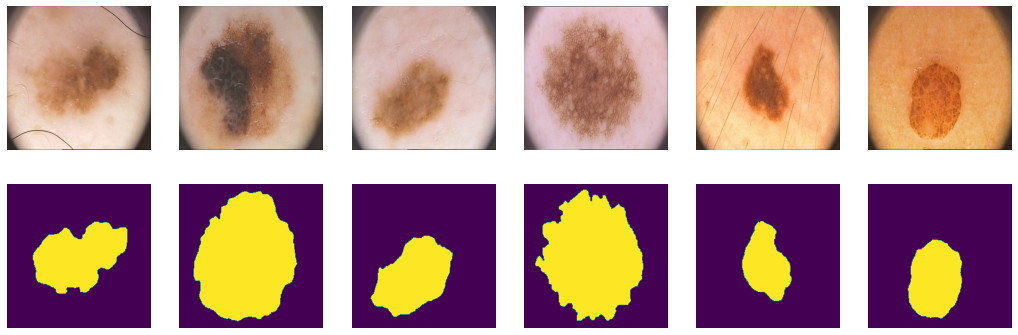

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
## из 200 элементов выбираем случайно 200 элементов и делим их по границам 100 и 150
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 10  ## было 25
## размерность №3, которую мы делаем №1, это три цвета?
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

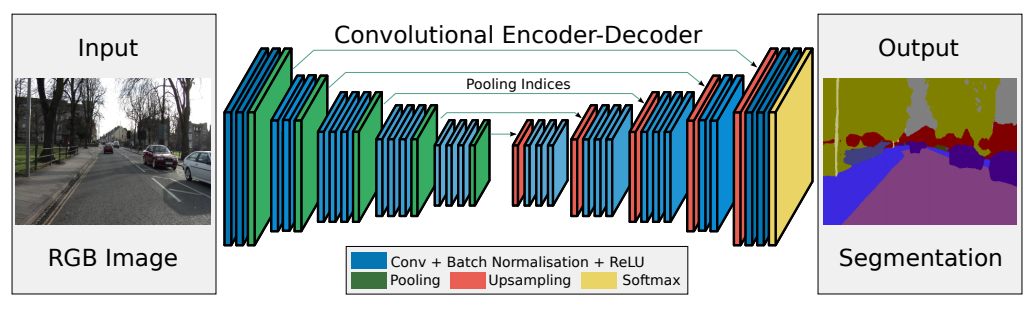

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [12]:
##
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [13]:
## https://github.com/vinceecws/SegNet_PyTorch/blob/master/SegNet.py
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
                              nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                              nn.BatchNorm2d(64),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                              nn.BatchNorm2d(64),
                              nn.ReLU()
                         )
        self.pool0 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                              nn.BatchNorm2d(128),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                              nn.BatchNorm2d(128),
                              nn.ReLU()
                         )
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                              nn.BatchNorm2d(256),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                              nn.BatchNorm2d(256),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                              nn.BatchNorm2d(256),
                              nn.ReLU()
                         )
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                              nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                              nn.BatchNorm2d(512),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                              nn.BatchNorm2d(512),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                              nn.BatchNorm2d(512),
                              nn.ReLU()
                         )
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU()
                               )
        self.bottleneck_pool = nn.MaxPool2d(2, stride=2, return_indices=True)  ## 16 -> 8
        self.bottleneck_upsample = nn.MaxUnpool2d(2, stride=2)  ## 8 -> 16
        self.bottleneck_dec_conv = nn.Sequential(
                                        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU()
                                  )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                              nn.BatchNorm2d(512),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                              nn.BatchNorm2d(512),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                              nn.BatchNorm2d(256),
                              nn.ReLU()
                         )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                              nn.BatchNorm2d(256),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                              nn.BatchNorm2d(256),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                              nn.BatchNorm2d(128),
                              nn.ReLU()
                         )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                              nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                              nn.BatchNorm2d(128),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                              nn.BatchNorm2d(64),
                              nn.ReLU()
                         )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                              nn.BatchNorm2d(64),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)  ## а где-то 2 матрицы на выходе
                         )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b0, ind4 = self.bottleneck_pool(self.bottleneck_conv(e3))
        b1 = self.bottleneck_dec_conv(self.bottleneck_upsample(b0, ind4))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b1, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))  # no activation ## про softmax?
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    ## ох, не хорошо править "оценочный" код...
    ## но иначе это все придется делать каждый раз перед обращением к iou
    outputs = torch.clamp(torch.sigmoid(outputs) * 2, 0, 1.999)
    ## все значения должны попасть в диапазон [0, 1,999] и byte() их превратит в 0 и 1?
    ## "уровень отсечки" для маски - 0,5 (после сигмоиды)
    ## наверное много проще можно, типа: torch.sigmoid(outputs) > 0.5? рукалицо

    '''squeeze() удаляет размерности размером 1.
    byte() превращает в uint8. 
    Округление до целых вниз. Нельзя после сигмоиды подавать?
    Все выходящее за пределы - 0
    что же ожидается на входе? 0 и 1, видимо
    '''
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0
    
    ## все, что имеет оценку ниже 0,5 оценивает в 0? 
    ## А остальное по 10 балльной шкале: 0,1, 0,2 ...?
    ## Зачем такие сложности?
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [14]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    y_pred = torch.sigmoid(y_pred)
    ## y_pred = torch.clamp(y_pred, 0, 1)  ## может потом кламп попробовать?
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).sum()
    ## по формуле второй на выходе разве не "массив" получается? Взял его сумму


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [15]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    ## загружаем один батч из валидации

    avg_loss_list = [] ## сохраню значения лоссов

    for epoch in range(epochs):
        ## tic = time() ## зачем неиспользуемые далее tic/toc?
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)  ##
            Y_batch = Y_batch.to(device)  ##
            ## 'хотя тут еще детачить надо было по идее' ?

            # set parameter gradients to zero
            opt.zero_grad()  ##

            # forward
            Y_pred = model(X_batch)  ##
            loss = loss_fn(Y_batch, Y_pred)  ##
            ## print(type(loss))
            loss.backward()  ## backward-pass
            opt.step()  ## update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

            ## откуда переполнение?
            del Y_pred, X_batch, Y_batch 
            torch.cuda.memory.empty_cache()
        ## toc = time()
        print('train_loss: %f' % avg_loss)
        avg_loss_list.append(avg_loss.item())

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device))
        Y_hat = Y_hat.detach().cpu()  # detach and put into cpu

        '''avg_val_loss = 0
        for X_batch, Y_batch in data_val:
            # data to device
            X_batch = X_batch.to(device)  ##
            Y_batch = Y_batch.to(device)  ##

            with torch.set_grad_enabled(False):
                Y_pred = model(X_batch)  ##
                loss = loss_fn(Y_batch, Y_pred)  ##

            # calculate loss to show the user
            avg_val_loss += loss / len(data_val)

            Y_hat = torch.cat((Y_hat, Y_pred))  ##

            ## откуда переполнение? И именно на валидации, вроде
            del Y_pred, X_batch, Y_batch 
            torch.cuda.memory.empty_cache()
        print('val_loss: %f' % avg_loss)
        Y_hat = Y_hat.detach().cpu()  # detach and put into cpu'''

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            ## четкие маски рисуем с "уровнем отсечки" - 0,5 (после сигмоиды)
            plt.subplot(3, 6, k+13)
            plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    
    print(*avg_loss_list)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
# так и не смог состыковать типы данных
'''def predict(model, data):
    model.to(device).eval()  # testing mode
    ## Y_pred = [ X_batch for X_batch, _ in data]  ## исходный вид
    Y_pred = [model(X_batch.to(device)) for X_batch in data]  ##
    return Y_pred  ## np.array(Y_pred)  ## исходный вариант'''

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    ## level = torch.tensor(0).to(device)  ## уровень отсечки для определения сегмента
    for X_batch, Y_label in data:
        ## <TODO>
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        with torch.set_grad_enabled(False):
            Y_pred = model(X_batch)  ## было Y_pred = predict(model, (X_batch, Y_label))
        scores += metric(Y_pred, Y_label).mean().item()  ## разве не .sum() д.б.?

        ## чистим память ручками. Почему так?
        del Y_pred, X_batch, Y_label 
        torch.cuda.memory.empty_cache()
    
    return scores/len(data)
    '''
    ## для оптимизации использования памяти 
        del Y_pred, X_batch, Y_label 
        torch.cuda.memory.empty_cache()
    '''

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)
optim = torch.optim.Adam(model.parameters())  ##

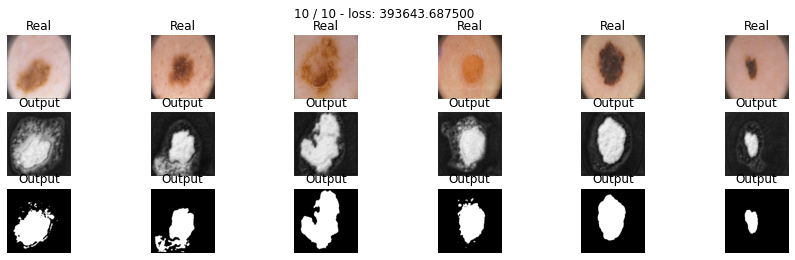

394357.5 394348.84375 392608.65625 400800.71875 395633.1875 397279.5625 390945.96875 396288.75 396591.71875 393643.6875


In [ ]:
max_epochs = 10
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.42400001287460326

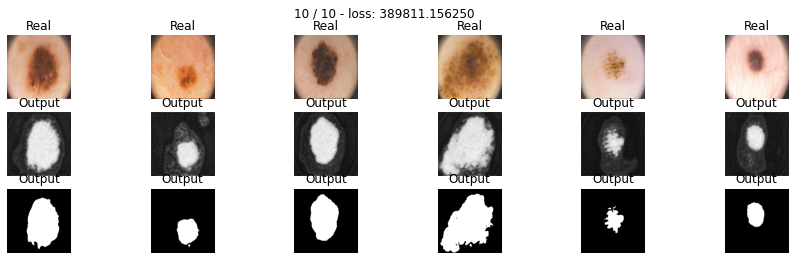

394442.03125 390964.8125 393566.375 388376.34375 392084.84375 389634.84375 393076.5 390143.84375 394937.15625 389811.15625


In [ ]:
## дообучимся
max_epochs = 10
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6940000176429748

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/segnet_bce.pth')

In [ ]:
'''model = SegNet().to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/segnet_bce.pth'))'''

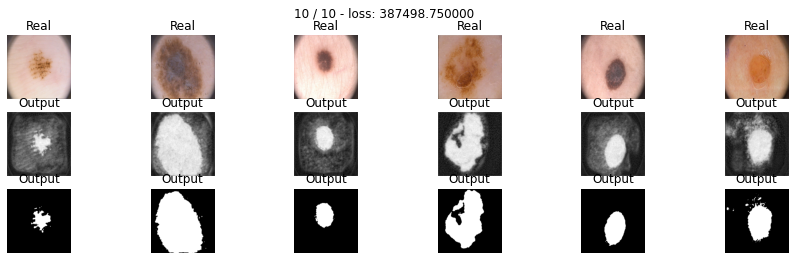

389650.125 388236.375 388595.28125 388086.5625 389343.25 390720.46875 391127.46875 390949.4375 387482.125 387498.75


In [ ]:
## дообучимся
max_epochs = 10
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.690000033378601

In [ ]:
## На последних 10 эпохах и лосс не очень падал и скор улучшения не показал

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i 2X_iY_i}{\sum_i(X_i+Y_i)}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


DL(y, pˆ) = 1 − (2ypˆ+ 1) / (y + ˆp + 1)  
https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b

In [ ]:
def dice_loss(y_real, y_pred):
    ## И что за численная нестабильность? Не делать сразу 1 / 256^2?
    ## делаю без 256 - не видел в других местах
    SMOOTH = 1e-8
    y_pred = torch.sigmoid(y_pred)
    num = (2 * y_real * y_pred).sum()  ##
    den =  (y_real + y_pred).sum()  ##
    ## 'numerator and denominator'
    res = 1 - (num + SMOOTH) / (den + SMOOTH)  ##
    return res

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

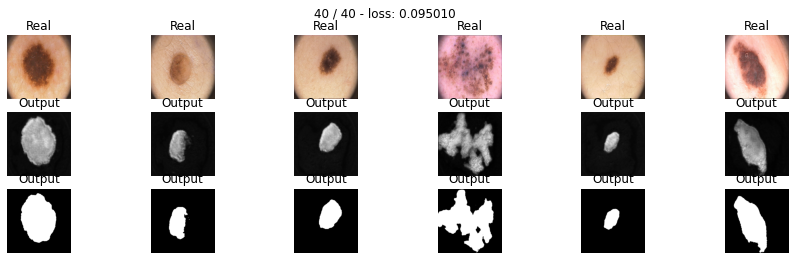

[0.10891960561275482, 0.11799126863479614, 0.1226729229092598, 0.11365152895450592, 0.10324013233184814, 0.09912116825580597, 0.12560220062732697, 0.08932153135538101, 0.09350022673606873, 0.09501009434461594]


In [ ]:
max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
torch.save(model_dice.state_dict(), '/content/gdrive/My Drive/segnet_dice.pth')

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.5520000219345093

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # hint: torch.clamp
    ## решил, что в формуле что-то попутано. Нашел в инетах вариант
    '''res = -((1 - F.sigmoid(y_pred))**gamma * y_real * torch.log(F.sigmoid(y_pred))
            + (1 - y_pred) * torch.log(1 - F.sigmoid(y_pred))).sum()  # sum переполняется?'''
    alpha = 1  ## решил сделать просто
    bce = bce_loss(y_real, y_pred)
    pt = torch.exp(-bce)
    res = alpha * torch.pow((1 - pt), gamma) * bce
    ## что здесь надо было делать?
    ## зачем нужно использовать torch.clamp? Только для второго варианта формулы?
    return res  ## your_loss


In [ ]:
model_focal = SegNet().to(device)
optimaizer = torch.optim.Adam(model_focal.parameters())

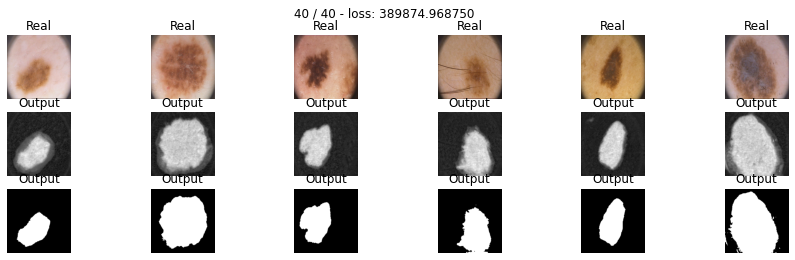

505228.78125 436098.75 412956.5625 411521.75 402073.03125 397988.875 404151.03125 402193.59375 405639.8125 398835.09375 398294.9375 393947.75 396056.5 396907.59375 397185.59375 395627.96875 398918.53125 395699.90625 394849.46875 394905.0 397855.0625 396915.6875 392911.0625 391372.625 393466.78125 395912.84375 394645.21875 397544.5625 394364.09375 389343.1875 392434.75 396102.0 396298.1875 401945.59375 397328.09375 395685.46875 399593.09375 402811.78125 396165.96875 389874.96875


In [ ]:
max_epochs = 40
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
torch.save(model_focal.state_dict(), '/content/gdrive/My Drive/segnet_focal.pth')

In [ ]:
'''model_focal = SegNet().to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/segnet_focal.pth'))'''

<All keys matched successfully>

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6760000348091125

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

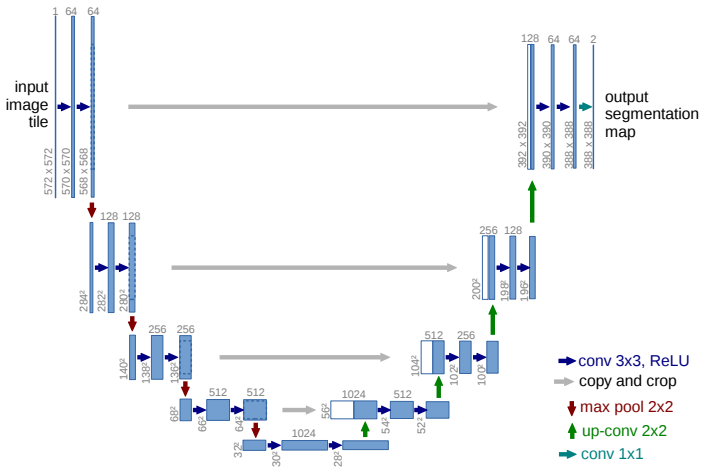

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
## создаем модель UNet
## судя по комментариям типа "32 -> 16", к счастью, можно использовать паддинги.
## в оригинале было без них, видимо
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
                              nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                              nn.ReLU()
                         )
        self.pool0 = nn.MaxPool2d(2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                              nn.ReLU()
                         )
        self.pool1 = nn.MaxPool2d(2, stride=2)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                              nn.ReLU()
                         )
        self.pool2 = nn.MaxPool2d(2, stride=2)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                              nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                              nn.ReLU()
                         )
        self.pool3 = nn.MaxPool2d(2, stride=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
                                    nn.ReLU()
                              )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                              nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                              nn.ReLU()
                         )
        self.upsample1 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                              nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                              nn.ReLU()
                         )
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                              nn.ReLU()
                         )
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)  
                              ## зачем часто делают 2 слоя на выходе?
                         )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(torch.cat((b, e3), dim=1)))
        d1 = self.dec_conv1(self.upsample1(torch.cat((d0, e2), dim=1)))
        d2 = self.dec_conv2(self.upsample2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(self.upsample3(torch.cat((d2, e0), dim=1)))  # no activation
        return d3

In [ ]:
unet_model_bce = UNet().to(device)
optimaizer = torch.optim.Adam(unet_model_bce.parameters())

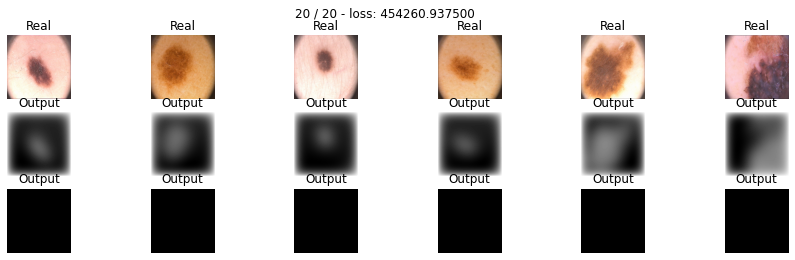

468096.6875 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375 454260.9375


In [ ]:
max_epochs = 20
train(unet_model_bce, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
torch.save(unet_model_bce.state_dict(), '/content/gdrive/My Drive/unet_model_bce.pth')

In [ ]:
score_model(unet_model_bce, iou_pytorch, data_val)

0.0

Теперь проверьте модель UNet c функцией потерь FocalLoss. 

In [ ]:
unet_model_focal = UNet().to(device) ##
optimaizer = torch.optim.Adam(unet_model_focal.parameters())

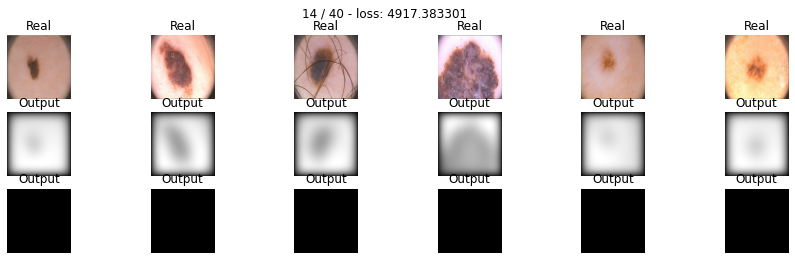

* Epoch 15/40


KeyboardInterrupt: ignored

In [ ]:
max_epochs = 40
train(unet_model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)  ##

In [ ]:
torch.save(unet_model_focal.model_bce.state_dict(), '/content/gdrive/My Drive/unet_model_focal.pth')

In [ ]:
score_model(unet_model_focal, iou_pytorch, data_val)  ##

Сделайте вывод, какая из моделей лучше.

# Отчет (6 баллов)
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.

Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

__________________

In [ ]:
## Всякие мои эксперименты

In [ ]:
!gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar

Downloading...
From: https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7
To: /content/PH2Dataset.rar
100% 116M/116M [00:00<00:00, 388MB/s] 


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]
## что значит resize() > 0.5? Попиксельно делает и получается картинка с 0 и 1?

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
## из 200 элементов выбираем случайно 200 элементов и делим их по границам 100 и 150
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10  ## было 25
## размерность №3, которую мы делаем №1, это три цвета?
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
import torch

In [ ]:
torch.clamp(torch.FloatTensor([-2 * 10**38, 0.3, 0.8, 3, 2**8]), 0, 9)

tensor([0.0000, 0.3000, 0.8000, 3.0000, 9.0000])

In [ ]:
torch.FloatTensor([-2 * 10**38, 0.8, 1.00001, 3, 2**8]).byte()

tensor([0, 0, 1, 3, 0], dtype=torch.uint8)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, level):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    ## ох, не хорошо править "оценочный" код...
    ## но иначе это все придется делать каждый раз перед обращением к iou
    outputs = torch.sigmoid(outputs) > level
    ## все значения должны попасть в диапазон [0, 1,999] и byte() их превратит в 0 и 1?
    ## "уровень отсечки" для маски - 0,5 (после сигмоиды)
    ## наверное много проще можно, типа: torch.sigmoid(outputs) > 0.5? рукалицо

    '''squeeze() удаляет размерности размером 1.
    byte() превращает в uint8. 
    Округление до целых вниз. Нельзя после сигмоиды подавать?
    Все выходящее за пределы - 0
    что же ожидается на входе? 0 и 1, видимо
    '''
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0
    
    ## все, что имеет оценку ниже 0,5 оценивает в 0? 
    ## А остальное по 10 балльной шкале: 0,1, 0,2 ...?
    ## Зачем такие сложности?
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

In [17]:
def score_model(model, metric, data, level):
    model.eval()  # testing mode
    scores = 0
    ## level = torch.tensor(0).to(device)  ## уровень отсечки для определения сегмента
    for X_batch, Y_label in data:
        ## <TODO>
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        with torch.set_grad_enabled(False):
            Y_pred = model(X_batch)  ## было Y_pred = predict(model, (X_batch, Y_label))
        scores += metric(Y_pred, Y_label, level).mean().item()  ## разве не .sum() д.б.?

        ## чистим память ручками. Почему так?
        del Y_pred, X_batch, Y_label 
        torch.cuda.memory.empty_cache()
    
    return scores/len(data)

In [18]:
model = SegNet().to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/segnet_bce.pth'))

<All keys matched successfully>

In [21]:
for i in range(10):
    level = 0.0 + 0.1 * i
    score = score_model(model, iou_pytorch, data_val, level)
    print(round(level, 1), score)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.0 0.058000001683831216
0.1 0.6680000185966491
0.2 0.6820000410079956
0.3 0.684000027179718
0.4 0.6960000038146973
0.5 0.700000011920929
0.6 0.6920000314712524
0.7 0.700000011920929
0.8 0.6959999918937683
0.9 0.6940000057220459
